In [2]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets

# Avoiding unnecessary log messges and warnings
import logging

logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True,
)

In [11]:
# Multiple ways to provide domain knowledge and tools or by causal graph
# By data

data

{'df':        Z0        Z1        W0        W1        W2        W3        W4     v0  \
 0     1.0  0.051565 -0.540007 -1.593027  0.889251 -0.053372 -2.691855  False   
 1     1.0  0.727361 -0.234058 -1.406265 -0.520958  0.742266 -0.532901   True   
 2     1.0  0.966926  0.164667 -0.629826  1.185725 -0.035330 -1.020308   True   
 3     1.0  0.361902 -1.143164 -0.869790 -0.318605  0.570548  0.490538   True   
 4     1.0  0.002051  1.296063  0.338730  0.165390 -3.042771 -2.372476   True   
 ...   ...       ...       ...       ...       ...       ...       ...    ...   
 9995  1.0  0.505781 -0.164249  0.508138  1.130536 -1.046329  0.963134   True   
 9996  1.0  0.478973  0.458515 -3.396724  1.399016  1.456539 -1.957314   True   
 9997  1.0  0.997372 -0.957799 -0.566546  0.703144 -0.186994 -1.314703   True   
 9998  0.0  0.903719  1.027499 -2.933049  1.625794 -0.096221 -2.340734   True   
 9999  1.0  0.370695  0.086001 -0.648032 -0.849608  1.252071 -2.009850   True   
 
               y  
 

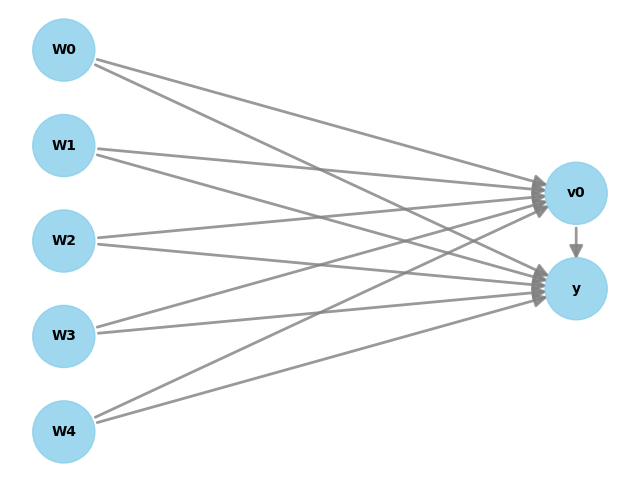

In [13]:
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    intrumental_variables=data["instrument_names"],
)

# visualize the graph
model.view_model()
# from IPython.display import Image, display

# display(Image(filename="causal_model.png"))

In [14]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W4,W3,U) = P(y|v0,W0,W1,W2,W4,W3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [15]:
# III. Estimate the target estimand using a statistical method.
propensity_strat_estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.dowhy.propensity_score_stratification"
)

print(propensity_strat_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W4,W3,U) = P(y|v0,W0,W1,W2,W4,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W4+W3
Target units: ate

## Estimate
Mean value: 10.028556344233067



In [16]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    method_params={
        "init_params": {
            "model_y": GradientBoostingRegressor(),
            "model_t": GradientBoostingRegressor(),
            "model_final": LassoCV(fit_intercept=False),
        },
        "fit_params": {},
    },
)
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W4,W3,U) = P(y|v0,W0,W1,W2,W4,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W4+W3 | 
Target units: ate

## Estimate
Mean value: 10.027188523155713
Effect estimates: [[10.02718852]]



In [17]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(
    identified_estimand,
    propensity_strat_estimate,
    method_name="placebo_treatment_refuter",
)
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:10.028556344233067
New effect:-0.00871847868852804
p value:0.98



# A new use cases of treatement analysis  -  https://zhuanlan.zhihu.com/p/362150318

   Treatment    Outcome        w0         s        w1
0   8.698829  17.415786 -1.645178  5.465457  0.361346
1  18.377336  37.138546  3.519238  3.693370  0.153596
2  18.690083  37.557667 -3.523702  0.257063  0.867012
3  12.215002  24.243920 -2.480043  8.232865  0.126435
4  15.020040  30.125952 -2.969198  0.360076  0.685574


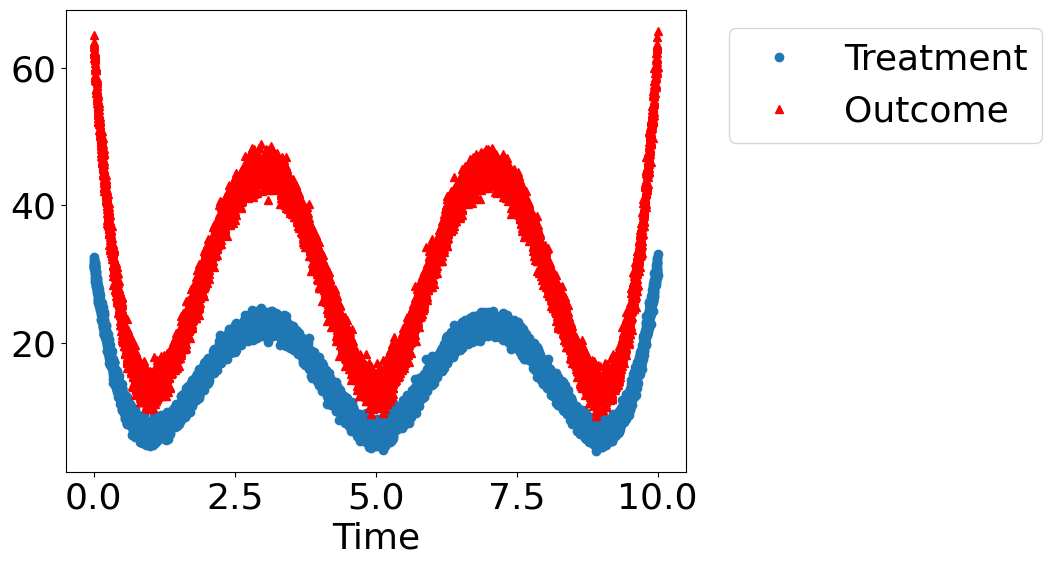

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy.datasets, dowhy.plotter

rvar = 1 if np.random.uniform() > 0.2 else 0
is_linear = (
    False  # A non-linear dataset. Change to True to see results for a linear dataset.
)
data_dict = dowhy.datasets.xy_dataset(
    10000, effect=rvar, num_common_causes=2, is_linear=is_linear, sd_error=0.2
)
df = data_dict["df"]
print(df.head())
dowhy.plotter.plot_treatment_outcome(
    df[data_dict["treatment_name"]],
    df[data_dict["outcome_name"]],
    df[data_dict["time_val"]],
)

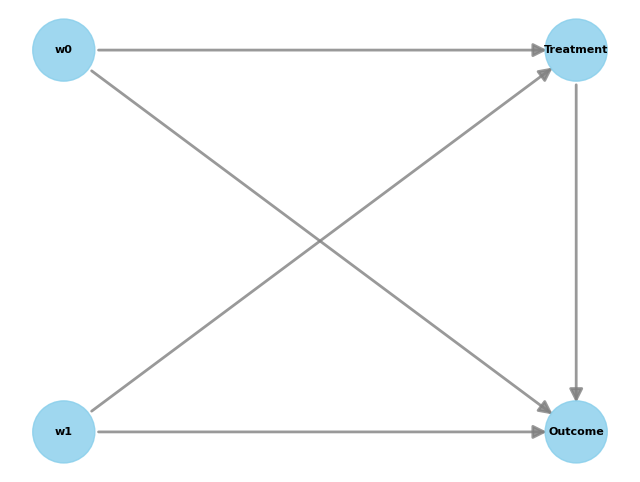

In [19]:
model = CausalModel(
    data=df,
    treatment=data_dict["treatment_name"],
    outcome=data_dict["outcome_name"],
    common_causes=data_dict["common_causes_names"],
    instruments=data_dict["instrument_names"],
)
model.view_model()

In [20]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w0,w1])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value=0,
    treatment_value=1,
    confidence_intervals=False,
    method_params={
        "init_params": {
            "model_y": GradientBoostingRegressor(),
            "model_t": GradientBoostingRegressor(),
            "model_final": LassoCV(fit_intercept=False),
            "featurizer": PolynomialFeatures(degree=2, include_bias=True),
        },
        "fit_params": {},
    },
)
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w0,w1])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

## Realized estimand
b: Outcome~Treatment+w0+w1 | 
Target units: ate

## Estimate
Mean value: 1.1780251160979947
Effect estimates: [[1.17802512]]



In [23]:
res_random = model.refute_estimate(
    identified_estimand, dml_estimate, method_name="random_common_cause"
)
print(res_random)

Refute: Add a random common cause
Estimated effect:1.1780251160979947
New effect:1.1519842775603726
p value:0.46

